In [611]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [612]:
grains = pd.read_csv('datasets/seeds.csv')

In [613]:
grains.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   0               210 non-null    float64
 1   1               210 non-null    float64
 2   2               210 non-null    float64
 3   3               210 non-null    float64
 4   4               210 non-null    float64
 5   5               210 non-null    float64
 6   6               210 non-null    float64
 7   variety_number  210 non-null    int64  
 8   variety         210 non-null    object 
dtypes: float64(7), int64(1), object(1)
memory usage: 14.9+ KB


In [614]:
grains

,0,1,2,3,4,5,6,variety_number,variety
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1,Kama wheat
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1,Kama wheat
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1,Kama wheat
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1,Kama wheat
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1,Kama wheat
...,...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3,Canadian wheat
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3,Canadian wheat
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3,Canadian wheat
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3,Canadian wheat


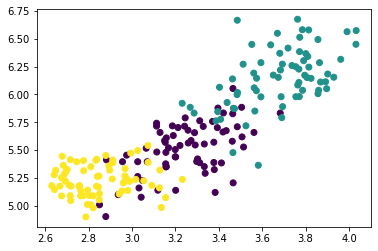

In [615]:
#Width vs Length
plt.scatter(grains['4'], grains['3'], c=grains['variety_number'])

In [616]:
X = grains.drop(['variety', 'variety_number'], axis=1).values

KMeans Method

Text(0.5, 0, 'K-clusters')

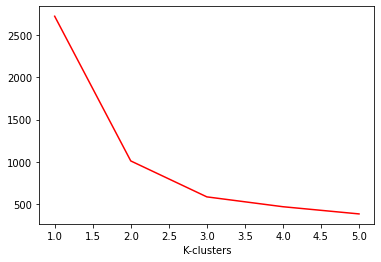

In [617]:
predictions = dict()
from sklearn.cluster import KMeans

inertias = list()
ks = list(range(1,6))

for k in ks:
    model_Kmeans = KMeans(n_clusters= k)
    model_Kmeans.fit(X)
    inertias.append(model_Kmeans.inertia_)

plt.plot(ks, inertias, '-r')
plt.xlabel('K-clusters')



In [618]:
def getDeltas(y_,x_):
    #calculate slopes this might seem confusing but its just a list compression of deltaY/deltaX
    return [(val[0] - y_[i]) / (val[1] - x_[i]) for i, val in enumerate(zip(y_[1:], x_[1:]))]

In [619]:
firstOrd = getDeltas(inertias, ks)
secondOrd = getDeltas(firstOrd,ks)
print(ks)
print(inertias)
print(firstOrd)
print(secondOrd)

[1, 2, 3, 4, 5]
[2719.852410177952, 1011.7123453151189, 587.3186115940426, 471.02714568221097, 386.1072678846765]
[-1708.1400648628332, -424.3937337210763, -116.29146591183166, -84.91987779753447]
[1283.7463311417569, 308.1022678092446, 31.371588114297197]


In [620]:
#K = 3 appears to be the best as the rate of change of the slope starts to approach 0 starting at 3 to 4
model_Kmeans = KMeans(n_clusters=3, random_state= 63)
labelsKmeans = model_Kmeans.fit_predict(X)
varieties = grains['variety']
df = pd.DataFrame({'labels':labelsKmeans, 'varieties':varieties})
ct = pd.crosstab(df['labels'], df['varieties'])

predictions['kmeans'] = labelsKmeans

In [621]:
#Looks like there are couple errors, lets try preprocessing the data
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
pipeline = make_pipeline(scaler, model_Kmeans)
labelscaledKmeans = pipeline.fit_predict(X)
df = pd.DataFrame({'labels':labelscaledKmeans, 'varieties':varieties})
ctscaled = pd.crosstab(df['labels'], df['varieties'])
print(f'Unscaled:\n{ct}\n\nScaled:\n{ctscaled}')

predictions['scale-kmeans'] = labelscaledKmeans



Unscaled:
varieties  Canadian wheat  Kama wheat  Rosa wheat
labels                                           
0                       0           1          60
1                      68           9           0
2                       2          60          10

Scaled:
varieties  Canadian wheat  Kama wheat  Rosa wheat
labels                                           
0                       4          62           5
1                       0           2          65
2                      66           6           0


Text(0, 0.5, 'Length')

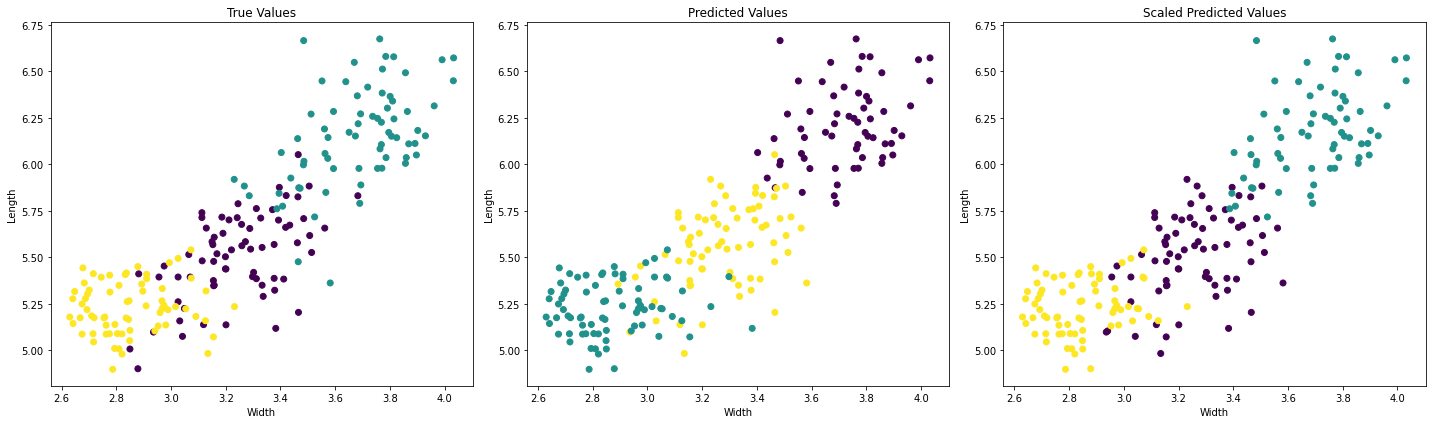

In [622]:
#Actual Scatter vs Predicted Scatter
fig = plt.figure(figsize=(20, 6), tight_layout = True)
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.scatter(X[:, 4], X[:, 3], c=grains['variety_number'])
ax1.set_title('True Values')
ax1.set_xlabel('Width')
ax1.set_ylabel('Length')

ax2.scatter(X[:, 4], X[:, 3], c=labelsKmeans)
ax2.set_title('Predicted Values')
ax2.set_xlabel('Width')
ax2.set_ylabel('Length')

ax3.scatter(X[:, 4], X[:, 3], c=labelscaledKmeans)
ax3.set_title('Scaled Predicted Values')
ax3.set_xlabel('Width')
ax3.set_ylabel('Length')

Hierarchical Clustering

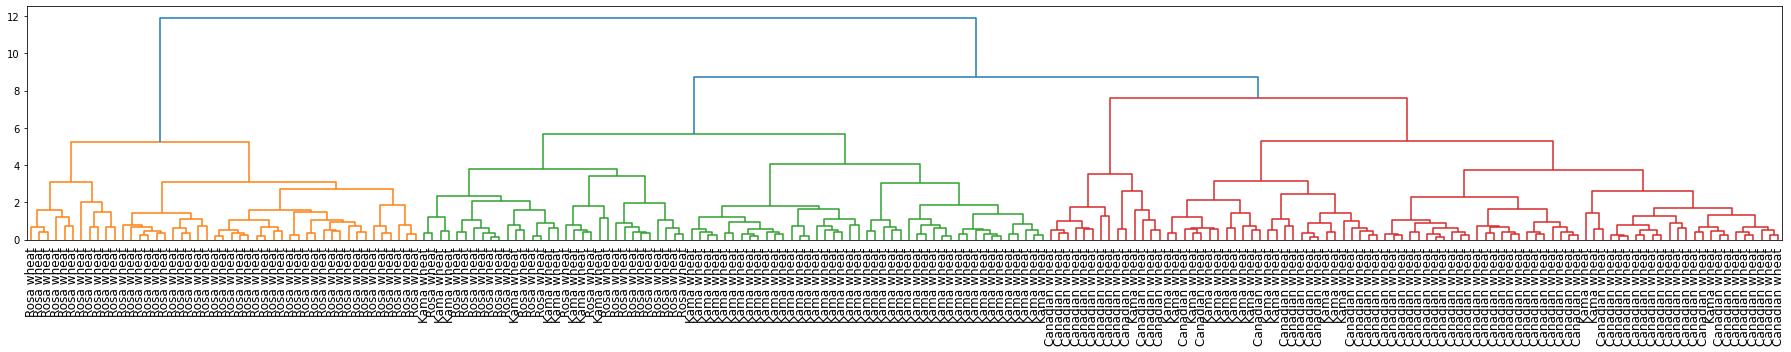

varieties,Canadian wheat,Kama wheat,Rosa wheat
labels,,,
1,0,0,47
2,0,52,23
3,70,18,0


In [623]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
mergings_cmplt = linkage(X, method='complete')
fig = plt.figure(figsize=(25, 5), tight_layout = True)

dendrogram(mergings_cmplt, 
           labels = list(varieties), 
           leaf_rotation=90, 
           leaf_font_size=12)
plt.show()
labelsCmplt = fcluster(mergings_cmplt, 8, criterion= 'distance')
df = pd.DataFrame({'labels': labelsCmplt, 'varieties': varieties})
ctcomplete = pd.crosstab(df['labels'], df['varieties'])

predictions['mergings_cmplt'] = labelsCmplt

ctcomplete

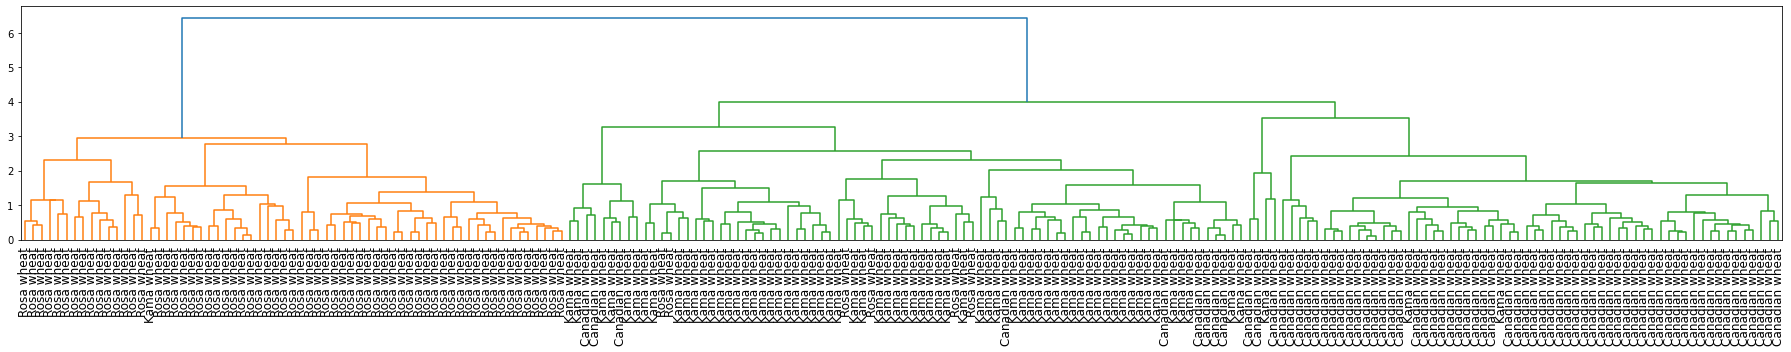

varieties,Canadian wheat,Kama wheat,Rosa wheat
labels,,,
1,0,1,64
2,9,66,6
3,61,3,0


In [624]:
mergings_avg = linkage(X, method='average')
fig = plt.figure(figsize=(25, 5), tight_layout = True)
dendrogram(mergings_avg, 
           labels = list(grains['variety']), 
           leaf_rotation=90, 
           leaf_font_size=12)
plt.show()
labelsAvg = fcluster(mergings_avg, 4, criterion= 'distance')
df = pd.DataFrame({'labels': labelsAvg, 'varieties': varieties})
ctavg = pd.crosstab(df['labels'], df['varieties'])

predictions['mergings_avg'] = labelsAvg

ctavg

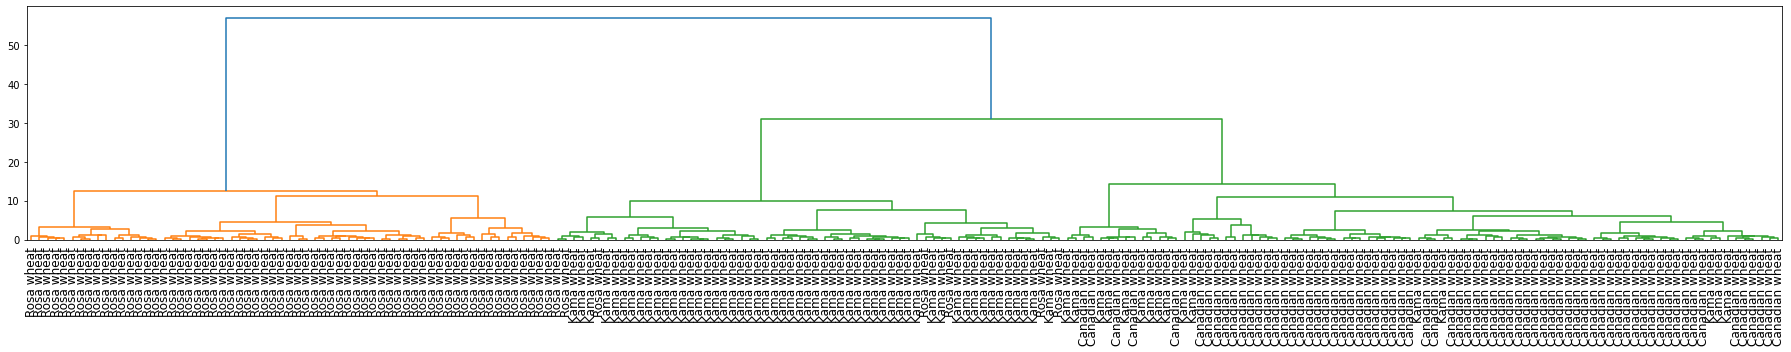

varieties,Canadian wheat,Kama wheat,Rosa wheat
labels,,,
1,0,0,63
2,0,54,7
3,70,16,0


In [625]:
mergings_ward = linkage(X, method='ward')
fig = plt.figure(figsize=(25, 5), tight_layout = True)
dendrogram(mergings_ward, 
           labels = list(grains['variety']), 
           leaf_rotation=90, 
           leaf_font_size=12)
plt.show()

labelsWard = fcluster(mergings_ward, 20, criterion= 'distance')
df = pd.DataFrame({'labels': labelsWard, 'varieties': varieties})
ctward = pd.crosstab(df['labels'], df['varieties'])

predictions['mergings_ward'] = labelsWard

ctward


In [626]:
print(f'Complete Linkage:\n{ctcomplete}\n\nAverage Linkage:\n{ctavg}\n\nWard Linkage:\n{ctward}')
#looks like the best one is average linkage

Complete Linkage:
varieties  Canadian wheat  Kama wheat  Rosa wheat
labels                                           
1                       0           0          47
2                       0          52          23
3                      70          18           0

Average Linkage:
varieties  Canadian wheat  Kama wheat  Rosa wheat
labels                                           
1                       0           1          64
2                       9          66           6
3                      61           3           0

Ward Linkage:
varieties  Canadian wheat  Kama wheat  Rosa wheat
labels                                           
1                       0           0          63
2                       0          54           7
3                      70          16           0


t-SNE

C:\Users\mbk61\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


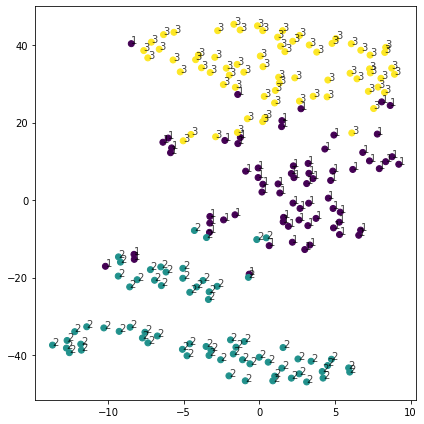

In [627]:
from sklearn.manifold import TSNE
tsne = TSNE(learning_rate=430, perplexity= 15, n_iter= 5000, random_state= 42)
# tsne = TSNE(learning_rate=500, perplexity= 50, n_iter= 5000)
tsne_features = tsne.fit_transform(X)

xs = tsne_features[:,0]
ys = tsne_features[:,1]

# Scatter plot, coloring by variety_numbers
fig = plt.figure(figsize=(6, 6), tight_layout = True)
plt.scatter(xs, ys, c=grains['variety_number'])
for x, y, val in zip(xs, ys, grains['variety_number']):
    plt.annotate(val, (x, y), fontsize=10, alpha=0.75)

plt.show()

PCA

Text(0.5, 0, 'PCA Feature')

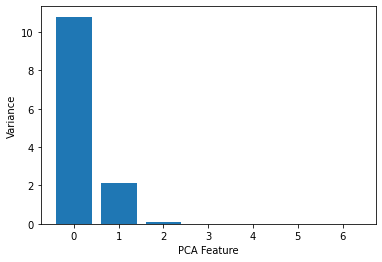

In [628]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X)
pca_features = range(pca.n_components_)
plt.bar(pca_features, pca.explained_variance_)
plt.xticks(pca_features)
plt.ylabel('Variance')
plt.xlabel('PCA Feature')


In [629]:
#looks like the rest of the features are very noisy only 2 components seems ideal
pca = PCA(n_components=2)
transformed = pca.fit_transform(X)
transformed.shape

(210, 2)

Text(0.5, 0, 'Feature 1')

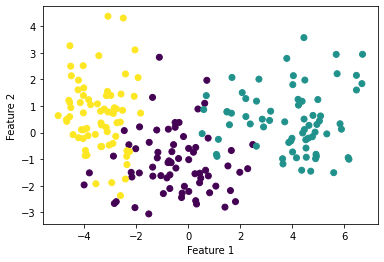

In [630]:
xs = transformed[:,0]
ys = transformed[:,1]
plt.scatter(xs, ys, c=grains['variety_number'])
plt.ylabel('Feature 2')
plt.xlabel('Feature 1')

K-Means PCA

Text(0.5, 0, 'K-clusters')

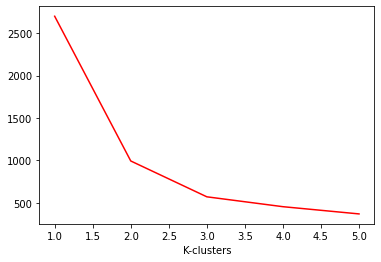

In [631]:
inertias = list()
ks = list(range(1,6))

for k in ks:
    model_Kmeans = KMeans(n_clusters= k)
    model_Kmeans.fit(transformed)
    inertias.append(model_Kmeans.inertia_)

plt.plot(ks, inertias, '-r')
plt.xlabel('K-clusters')

In [632]:
firstOrd = getDeltas(inertias, ks)
secondOrd = getDeltas(firstOrd,ks)
print(ks)
print(inertias)
print(firstOrd)
print(secondOrd)
#looks like 3 is decent
model_Kmeans = KMeans(n_clusters=3, random_state= 63)

[1, 2, 3, 4, 5]
[2700.861445515955, 992.8828527475772, 569.8898900140497, 453.37864534384045, 368.08914074202795]
[-1707.978592768378, -422.9929627335275, -116.51124467020924, -85.2895046018125]
[1284.9856300348504, 306.4817180633183, 31.22174006839674]


In [633]:
from sklearn.metrics import precision_score, recall_score, f1_score
def preds_process_metrics(predictions, clusters = 3, average = 'macro', showct = True):
    y = grains['variety_number']
    transcriptCats = {'Canadian wheat': 3, 'Kama wheat': 1, 'Rosa wheat': 2}
    sep = '_'
    
    for key in predictions:
        transcription = dict()
        label = predictions[key]
        
        if np.max(label) >= clusters:
            label = label - 1

        df = pd.DataFrame({'labels': label, 'varieties': varieties})
        ct = pd.crosstab(df['labels'], df['varieties'])

        for name, keys in ct.items():
            transcription[keys.idxmax(axis= 0)] = name

        y_pred = df['labels'].map(transcription).map(transcriptCats)
        print(transcription)
        
        print(f'{key}:\n{sep*50}')
        if showct:
            print(f'{ct}\n{sep*50}')

        # precision = precision_score(y, y_pred, average = average)
        # recall = recall_score(y, y_pred, average= average)
        # f1 = f1_score(y, y_pred, average= average)

        # print(f'Precision: {precision}\nRecall: {recall}\nF1: {f1}\n')


KMeans With PCA

In [634]:
#K-Means PCA
pca_kmeans = make_pipeline(pca, model_Kmeans)
pca_scale_kmeans = make_pipeline(scaler, pca, model_Kmeans)

predictions['pca_kmeans'] = pca_kmeans.fit_predict(X)
predictions['pca_scale_kmeans'] = pca_scale_kmeans.fit_predict(X)

KMeans TSNE

In [635]:
#K-Means TSNE
tsne_scale = make_pipeline(scaler, tsne)
transformed_tsne_scale = tsne_scale.fit_transform(X)

tsne_features = tsne.fit_transform(X)
tsne_kmeans = model_Kmeans

predictions['tsne_scale_kmeans'] = model_Kmeans.fit_predict(transformed_tsne_scale)
predictions['tsne_kmeans'] = tsne_kmeans.fit_predict(tsne_features)

C:\Users\mbk61\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\mbk61\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Hierarchical Cluster PCA

Hierarchical Cluster TSNE

In [636]:
mergings_avg_tsne = linkage(tsne_features, method= 'average'), 27
mergings_cmplt_tsne =linkage(tsne_features, method= 'complete'), 45
mergings_ward_tsne =linkage(tsne_features, method= 'ward'), 250

mergings_avg_tsne_scale = linkage(transformed_tsne_scale, method= 'average'), 30
mergings_cmplt_tsne_scale =linkage(transformed_tsne_scale, method= 'complete'), 45
mergings_ward_tsne_scale =linkage(transformed_tsne_scale, method= 'ward'), 250

mergings_avg_tsne_label = fcluster(mergings_avg_tsne[0], mergings_avg_tsne[1], criterion= 'distance')
mergings_cmplt_tsne_label = fcluster(mergings_cmplt_tsne[0], mergings_cmplt_tsne[1], criterion= 'distance')
mergings_ward_tsne_label = fcluster(mergings_ward_tsne[0], mergings_ward_tsne[1], criterion= 'distance')

mergings_avg_tsne_scale_label = fcluster(mergings_avg_tsne_scale[0], mergings_avg_tsne_scale[1], criterion= 'distance')
mergings_cmplt_tsne_scale_label = fcluster(mergings_cmplt_tsne_scale[0], mergings_cmplt_tsne_scale[1], criterion= 'distance')
mergings_ward_tsne_scale_label = fcluster(mergings_ward_tsne_scale[0], mergings_ward_tsne_scale[1], criterion= 'distance')

predictions['mergings_avg_tsne'] = mergings_avg_tsne_label
predictions['mergings_cmplt_tsne'] = mergings_cmplt_tsne_label
predictions['mergings_ward_tsne'] = mergings_ward_tsne_label

predictions['mergings_avg_tsne_scale'] = mergings_avg_tsne_scale_label
predictions['mergings_cmplt_tsne_scale'] = mergings_cmplt_tsne_scale_label
predictions['mergings_ward_tsne_scale'] = mergings_ward_tsne_scale_label


Model Eval

In [637]:
preds_process_metrics(predictions, average= "macro", showct=True)

kmeans:
__________________________________________________
varieties  Canadian wheat  Kama wheat  Rosa wheat
labels                                           
0                       0           1          60
1                      68           9           0
2                       2          60          10
__________________________________________________
scale-kmeans:
__________________________________________________
varieties  Canadian wheat  Kama wheat  Rosa wheat
labels                                           
0                       4          62           5
1                       0           2          65
2                      66           6           0
__________________________________________________
mergings_cmplt:
__________________________________________________
varieties  Canadian wheat  Kama wheat  Rosa wheat
labels                                           
0                       0           0          47
1                       0          52          23
2      